In [1]:
import sys
sys.path.append('/Users/huangxingyue/Desktop/NYU MFE/12 Capstone')
import numpy as np
import pandas as pd
import math
from Pricing.MC_simulation import simulateSABRMonteCarloEuler, simulateSABRMonteCarloMilstein, drawTwoRandomNumbers
from Fitter.fitter import Fitter
from Pricing.BS import black, dPlusBlack, dMinusBlack, find_ivol
from matplotlib import pyplot as plt

In [2]:
fitter=Fitter('market_data.xlsx')
results=fitter.calibration() #Hagan lognormal implementation
ivols=fitter.ivol_SABR(results['alpha'],results['beta'],results['rho'],results['nu'])
params=results['params']

### Take swaption of 5Y tenor and 1Y expiry as an example

In [3]:
factors=params.loc[10,:][2:]
vols=ivols.loc[10,:]
print ('params:\n', factors)
print ('ivols:\n', vols)

('params:\n', F        0.018623
alpha    0.017217
beta     0.211957
rho      0.279610
nu       0.383014
Name: 10, dtype: float64)
('ivols:\n', tenor     5.000000
expiry    1.000000
F         0.018623
-150      0.725720
-100      0.526692
-50       0.444822
-25       0.421135
0         0.404200
25        0.392014
50        0.383195
100       0.372069
150       0.366024
Name: 10, dtype: float64)


In [4]:
# Run Monte-Carlo simulation under Euler scheme and Milstein scheme
forwards1=simulateSABRMonteCarloEuler(100000,78, 1, vols['F'], factors[1],factors[2],factors[3],factors[4])
forwards2=simulateSABRMonteCarloMilstein(100000,78, 1, vols['F'], factors[1],factors[2],factors[3],factors[4])

In [5]:
p1=[] #MC simulated option price
p2=[] #BS predicted price by Hagan lognormal
for K_spread in vols.index.tolist()[3:]:
    option=[max(0, item-(vols['F']+K_spread/10000.)) for item in forwards1]
    p1.append(sum(option)/len(option))
    p2.append(black(vols['F'],(vols['F']+K_spread/10000.),1,vols[K_spread],1))

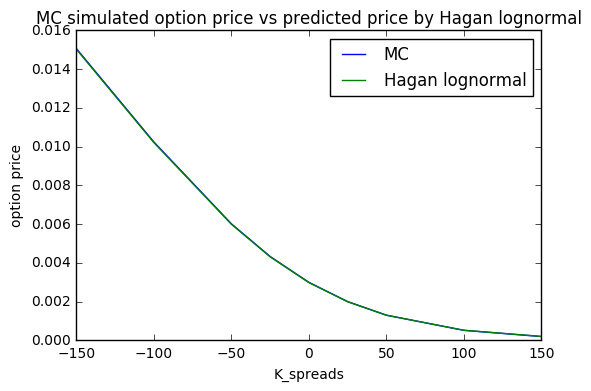

In [6]:
plt.plot(vols.index.tolist()[3:],p1,label='MC')
plt.plot(vols.index.tolist()[3:],p2,label='Hagan lognormal')
plt.title('MC simulated option price vs predicted price by Hagan lognormal')
plt.xlabel('K_spreads')
plt.ylabel('option price')
plt.legend()
plt.show()

In [7]:
ivols_hagan=vols.values[3:]
ivols_MC=[]
for counter, K_spread in enumerate(vols.index.tolist()[3:]):
    ivols_MC.append(find_ivol(p1[counter],vols['F'],vols['F']+K_spread/10000.,1))

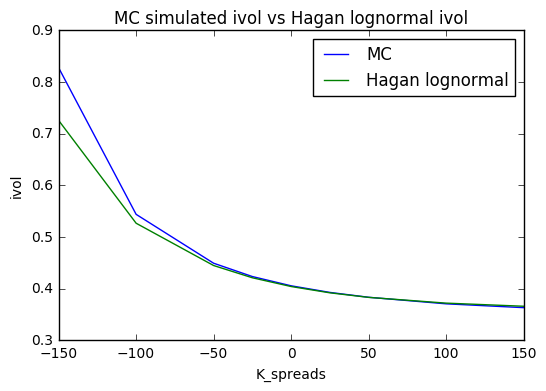

In [8]:
plt.plot(vols.index.tolist()[3:],ivols_MC,label='MC')
plt.plot(vols.index.tolist()[3:],ivols_hagan,label='Hagan lognormal')
plt.title('MC simulated ivol vs Hagan lognormal ivol')
plt.xlabel('K_spreads')
plt.ylabel('ivol')
plt.legend()
plt.show()